### *cis*- and *trans*-QTL mapping with tensorQTL

This notebook provides examples for running *cis*- and *trans*-QTL mapping with tensorQTL, using open-access data from the [GEUVADIS](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEUV-1/) project.

#### Requirements
An environment configured with a GPU and ~50GB of memory.

#### Test dataset

*Note: these files are provided for testing/benchmarking purposes only. They do not constitute an official release from the GEUVADIS project, and no quality-control was applied.*

Genotypes in PLINK2 format (chr18 only), and normalized expression data are available [in this repository](./data/); the full dataset is available at [gs://gtex-resources/test_data/geuvadis](https://console.cloud.google.com/storage/browser/gtex-resources/test_data/geuvadis) ([requester pays](https://cloud.google.com/storage/docs/requester-pays)).

In [ ]:
import os
os.chdir('/cluster2/home/futing/Project/HiCQTL/merged/CRC53')
import pandas as pd
import torch
import tensorqtl
import matplotlib.pyplot as plt
from tensorqtl import pgen, cis, trans, post
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch: {torch.__version__} (CUDA {torch.version.cuda}), device: {device}")
print(f"pandas: {pd.__version__}")

#### 预处理

In [ ]:
expression_file = '/cluster2/home/futing/Project/HiCQTL/merged/CRC53/phenotype/CRC53.bed'
ex = pd.read_csv(expression_file, sep='\t')
filtered = ex.loc[~ex.iloc[:, 3:].isna().any(axis=1)]  # 去掉所有全为NaN的行
# filtered.dropna(axis=0)  # 去掉所有含有NaN的行
filtered.rename(columns={'chrom':'#chr'}, inplace=True)
filtered.loc[:,'gene_id'] = filtered.index # bin id改为gene id
filtered = filtered[['#chr', 'start', 'end', 'gene_id'] + list(filtered.columns[3:-1])]
filtered.loc[:,'#chr'] = filtered.loc[:,'#chr'].str.replace('#chr', '', regex=False)
filtered.to_csv('./phenotype/CRC53_Aug15.bed', sep='\t', index=False)

/tmp/ipykernel_7491/1185128448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.rename(columns={'chrom':'#chr'}, inplace=True)
/tmp/ipykernel_7491/1185128448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.loc[:,'gene_id'] = filtered.index # bin id改为gene id


In [ ]:
filtered =pd.read_csv('./phenotype/CRC_Jun53fil.bed', sep='\t')
# filtered =filtered.drop(columns=['chr', 'start', 'end'])  # 去掉chr, start, end列
# filtered = filtered.set_index('gene')  # 设置gene为索引
filtered =filtered.dropna(axis=0)  # 去掉只要存在一个NaN的列
filtered.isna().sum(axis=1).value_counts()
# filtered.to_csv('./phenotype/CRC53_Aug04fil.bed', sep='\t', index=False)

/tmp/ipykernel_32079/593170257.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered =pd.read_csv('./phenotype/CRC_Jun53fil.bed', sep='\t')


#### 读入数据

In [ ]:
# define paths to data
geno='CRC53'
plink_prefix_path = f'/cluster2/home/futing/Project/HiCQTL/merged/CRC53/genotype/{geno}/{geno}'
expression_bed = './phenotype/CRC53_0901.bed'
# covariates_file = 'genotype_pc5.eigenvec.txt'
covariates_file ='/cluster2/home/futing/Project/HiCQTL/merged/CRC53/covariate/covariate.txt'
prefix = 'CRC'
# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

# PLINK reader for genotypes
pgr = pgen.PgenReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.variant_df
phenotype_df=phenotype_df.loc[:,covariates_df.index]

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:409: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype_df = pd.read_csv(phenotype_bed, sep='\t', index_col=3, dtype={'#chr':str, '#Chr':str})
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:423: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_df.groupby('chr', sort=False, group_keys=False).apply(lambda x: x.sort_values(['start', 'end']))


In [8]:
# 每个样本SNP型，SNP的位置，表型数据，协方差矩阵
genotype_df.shape,variant_df.shape,phenotype_df.shape,phenotype_pos_df.shape,covariates_df.shape

((12852925, 53), (12852925, 3), (523925, 53), (523925, 3), (53, 7))

In [11]:
# genotype_df.replace({-9: 0}, inplace=True)  # 将-9替换为0
genotype_df.loc[genotype_df.index=='rs12567639',:]

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,DKO,HCT116,SW480
rs12567639,-9,2,1,1,1,2,1,-9,-9,1,...,1,-9,1,1,1,1,1,-9,-9,1


In [9]:
genotype_df.apply(lambda x: x.value_counts(), axis=0)

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,DKO,HCT116,SW480
-9,10293183,10594657,10503399,10433684,10501173,10362329,9686587,10592589,11251128,10394268,...,10278638,10598608,10557395,9789015,10430361,10991605,10450457,9867021,9488675,11174249
1,1256954,1018669,1089975,1208874,1128700,1259728,1662253,1103618,540653,1278560,...,1275645,1096369,1166762,1606789,1206333,742019,1211901,1810537,2070001,443742
2,1302788,1239599,1259551,1210367,1223052,1230868,1504085,1156718,1061144,1180097,...,1298642,1157948,1128768,1457121,1216231,1119301,1190567,1175367,1294249,1234934


In [ ]:
fil=(genotype_df == -9).sum(axis=1)
genotype_df= genotype_df.loc[fil==0, :]
variant_df = variant_df.loc[variant_df.index.isin(genotype.index), :]

### *cis*-QTL: nominal p-values for all variant-phenotype pairs

In [4]:
# map all cis-associations (results for each chromosome are written to file)

# all genes
cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, prefix, covariates_df=covariates_df)

# genes on chr18
# cis.map_nominal(genotype_df, variant_df,
#                 phenotype_df.loc[phenotype_pos_df['chr'] == '18'],
#                 phenotype_pos_df.loc[phenotype_pos_df['chr'] == '18'],
#                 prefix, covariates_df=covariates_df)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 53 samples
  * 523925 phenotypes
  * 7 covariates
  * 12852925 variants
  * cis-window: ±1,000,000
    ** dropping 519125 phenotypes on chrs. without genotypes
  * checking phenotypes: 4800/4800
  * Computing associations
    Mapping chromosome 22
    processing phenotype 4800/4800
    time elapsed: 0.35 min
    * writing output
done.


In [3]:
# load results
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,570035,rs149898293,-999894,-1004893,0.009434,1,1,0.647635,-0.065785,0.142946
1,570035,rs5752024,-999765,-1004764,0.754717,19,26,0.418707,0.023123,0.028325
2,570035,rs151031039,-998909,-1003908,0.056604,4,6,0.014956,0.129791,0.051244
3,570035,chr22_24946177_G_A,-998824,-1003823,0.009434,1,1,0.051991,0.320694,0.160557
4,570035,chr22_24946413_A_C,-998588,-1003587,0.009434,1,1,0.802369,0.050166,0.199231


In [10]:
counts = pairs_df['phenotype_id'].value_counts()
print(counts)

phenotype_id
574585    13508
574584    13507
574586    13500
574562    13493
574553    13492
          ...  
574974     5759
574975     5733
574976     5698
574977     5655
574978     5631
Name: count, Length: 4800, dtype: int64


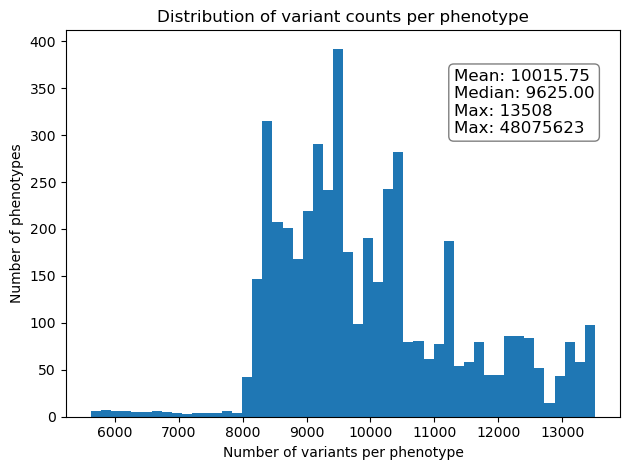

In [13]:
import matplotlib.pyplot as plt
counts.plot(kind='hist', bins=50)
plt.xlabel("Number of variants per phenotype")
plt.ylabel("Number of phenotypes")
plt.text(0.7, 0.9, f"Mean: {counts.mean():.2f}\nMedian: {counts.median():.2f}\nMax: {counts.max()}\nMax: {counts.sum()}",
		 transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.title("Distribution of variant counts per phenotype")
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'{prefix}.cis_qtl_pairs10k.22.hist2.png', dpi=300)

### *cis*-QTL: empirical p-values for phenotypes

In [ ]:
# all genes
cis_df = cis.map_cis(genotype_df, variant_df, phenotype_df, phenotype_pos_df, covariates_df=covariates_df,
	warn_monomorphic=False)

# genes on chr18
# cis_df = cis.map_cis(genotype_df, variant_df, 
#                      phenotype_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      covariates_df=covariates_df, seed=123456)
# compute q-values (in practice, this must be run on all genes, not a subset)
post.calculate_qvalues(cis_df, fdr=0.1, qvalue_lambda=0.85)

cis-QTL mapping: empirical p-values for phenotypes
  * 53 samples
  * 523925 phenotypes
  * 7 covariates
  * 12852925 variants
  * cis-window: ±1,000,000
    ** dropping 519125 phenotypes on chrs. without genotypes
  * checking phenotypes: 4800/4800
  * computing permutations
    processing phenotype 25/4800

In [12]:
cis_df.to_csv(f'{prefix}.cis_qtl_pairs.22.csv')
# cis_df = pd.read_csv(f'{prefix}.cis_qtl_pairs.22.csv')
# cis_df.set_index(['phenotype_id'], inplace=True)

In [14]:
genotype_df.head()

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,DKO,HCT116,SW480
rs116400033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
chr1_51884_T_C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
chr1_51915_G_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
rs141149254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
rs10399749,0,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


<Axes: >

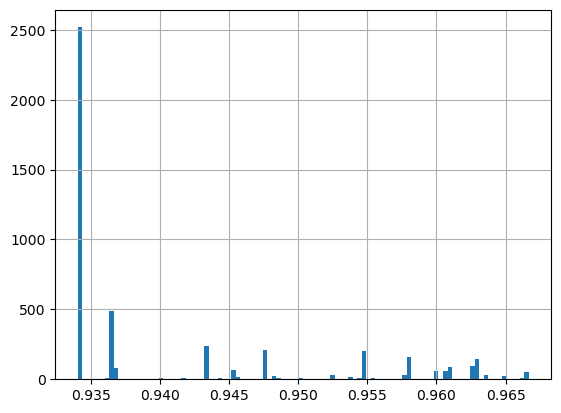

In [13]:
cis_df.qval.hist(bins=100)

### *trans*-QTL mapping

In [ ]:
# run mapping
# to limit output size, only associations with p-value <= 1e-5 are returned
trans_df = trans.map_trans(genotype_df, phenotype_df, covariates_df, batch_size=10000,
                           return_sparse=True, pval_threshold=1e-5, maf_threshold=0.05)

In [28]:
# remove cis-associations
trans_df = trans.filter_cis(trans_df, phenotype_pos_df, variant_df, window=5000000)

In [20]:
trans_df.head()

,variant_id,phenotype_id,pval,b,b_se,af
0,chr1_51479,113324,2.660085e-06,-0.533680,0.031414,0.666667
1,chr1_51479,113325,1.921269e-09,-0.367525,0.006427,0.666667
2,chr1_51479,113352,4.744198e-08,-0.586417,0.017527,0.666667
3,chr1_51479,113965,6.395684e-06,0.595992,0.040731,0.666667
4,chr1_51479,138685,9.522360e-06,-0.370109,0.027076,0.666667


In [52]:
# trans_df.to_csv(f'{prefix}_trans_qtl_pairs.22.csv', index=False)
cis_df.to_csv(f'{prefix}_cis_qtl_pairs.22.csv', index=False)

### 绘图

In [13]:
# 统计每个样本鉴定的SNP数量
nSNP=(genotype_df>0).sum(axis=0).sort_values(ascending=False)
# 统计每个SNP出现次数的频数
nfreq=(genotype_df>0).sum(axis=1).value_counts()

Text(0.5, 1.0, 'SNP Frequency Distribution')

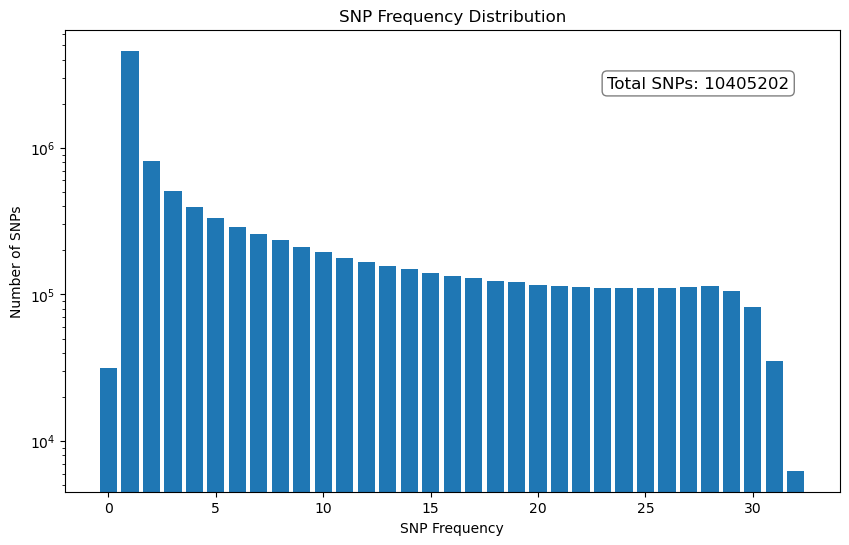

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(nfreq.index, nfreq.values)
plt.yscale('log')
# plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.text(0.7,0.9, f"Total SNPs: {nfreq.sum()}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# plt.xticks(range(0, 14, 1))
plt.xlabel('SNP Frequency')
plt.ylabel('Number of SNPs')
plt.title('SNP Frequency Distribution')

In [12]:
# barplot
plt.figure(figsize=(10, 6))
plt.bar(nSNP.index, nSNP.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.xlabel('Samples')
plt.ylabel('Number of SNPs')
plt.title('Number of SNPs per samples')

NameError: name 'nSNP' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
trans_df.shape,genotype_df.shape,cis_df.shape

In [36]:
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,574263,chr22_46085605_C_T,-999396,-1004395,0.5000,32,32,NaN,NaN,NaN
1,574263,rs8135478,-998896,-1003895,0.8000,2,13,0.949320,0.012576,0.195794
2,574263,chr22_46086842_G_C,-998159,-1003158,0.5000,32,32,NaN,NaN,NaN
3,574263,rs9626891,-997933,-1002932,0.5625,31,28,0.595991,-0.117615,0.218890
4,574263,chr22_46087271_G_A,-997730,-1002729,0.5000,32,32,NaN,NaN,NaN


### 手动计算

In [3]:
# phenotype_df.to_csv(f'{prefix}_phenotype_df.22.csv')
# genotype_df.to_csv(f'{prefix}_genotype_df.22.csv')
phenotype_df = pd.read_csv(f'{prefix}_phenotype_df.22.csv', index_col=0)
genotype_df = pd.read_csv(f'{prefix}_genotype_df.22.csv', index_col=0)
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
cis_df = pd.read_csv(f'{prefix}_cis_qtl_pairs.22.csv', index_col=0)

In [55]:
print(f"Phenotype DataFrame shape: {phenotype_df.shape}")
print(f"Genotype DataFrame shape: {genotype_df.shape}")
print(f"Pairs DataFrame shape: {pairs_df.shape}")
print(f"Cis DataFrame shape: {cis_df.shape}")

Phenotype DataFrame shape: (539677, 32)
Genotype DataFrame shape: (10405202, 32)
Pairs DataFrame shape: (6690417, 10)
Cis DataFrame shape: (716, 17)


In [59]:
cis_df.head()

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval
phenotype_id,,,,,,,,,,,,,,,,,
574263,3151,1.066471,576.776855,20.738218,0.000681,rs454700,592427,587428,6,8,0.875000,0.000341,0.348447,0.082949,0.300770,0.294515,0.99975
574264,3151,1.113155,474.488525,18.313345,0.001288,rs35637220,-881082,-886081,28,17,0.722222,0.000298,-0.791011,0.185912,0.420558,0.403904,0.99975
574265,3161,1.076256,411.445709,18.218555,0.004712,rs4374471,-567098,-572097,29,23,0.636364,0.001452,0.590806,0.163389,0.840016,0.838779,0.99975
574266,3164,1.092622,221.665817,13.682797,0.007830,rs4823607,67280,62281,1,1,0.972222,0.000516,0.795607,0.197195,0.801720,0.799526,0.99975
574267,3166,1.104851,288.316620,16.236423,0.004295,rs1474857,119726,114727,6,16,0.750000,0.000641,-0.410243,0.103934,0.684332,0.671096,0.99975


### actual running

In [10]:
from manual import SNPExpressionAnalyzer
import os

ModuleNotFoundError: No module named 'manual'

In [ ]:
# 04 actual running
analyzer = SNPExpressionAnalyzer()
analyzer.set_data_directly(genotype_df,phenotypedf, cismapdf)
# analyzer.preprocess_genotype()
# 批量分析
print("\n=== 批量分析 ===")
analyzer.batch_analysis(method='t_test')

# 显示汇总统计
print("\n=== 汇总统计 ===")
analyzer.get_summary_statistics()